# Sech - Positive Weights

In [2]:
import cvxpy as cp

from math import exp, log, sqrt
from matplotlib import pyplot as plot
from scipy.optimize import fsolve
from scipy.stats import linregress
from sympy import Symbol, cosh, lambdify, pi

import DistExampB as db

from Map import LogRatio
from LocUtil import Grid1, LogGrid1, MinMax, IndexOf, Sub, UnZip

## Set Up

#### constants

In [3]:
nPlot = 201

#### problem

In [4]:
dist = db.ExampB()

#### maping

In [5]:
xSym = Symbol('x')
zSym = Symbol('z')
map_ = LogRatio(xSym, zSym, xRange=(0, 2))
map_.forSym

log(x/(2 - x))

In [6]:
X2Z = map_.Forward
Z2X = map_.Inverse

#### bases

In [7]:
hSym = Symbol('h', positive=True)
zkSym = Symbol('zk', real=True)

In [8]:
baseZ = 1/pi * 1 / cosh((zSym - zkSym) / hSym)
baseZ

1/(pi*cosh((z - zk)/h))

In [9]:
BaseZ = lambdify((zSym,zkSym,hSym), baseZ)

## Constrained Fit to PDF

In [10]:
PdfZ = lambda z: dist.Pdf(map_.Inverse(z))

In [11]:
truncStep = 0.01

In [12]:
zMin = fsolve(lambda z: PdfZ(z) - truncStep, -3)[0]
zMax = fsolve(lambda z: PdfZ(z) - truncStep, 6)[0]
zMin,zMax

(-3.1026021373001056, 6.393525850353921)

In [13]:
def Fit(zRange, nSech):
	# parse arguments
	assert(1 < nSech)
	zMin,zMax = zRange
	
	sechZ = Grid1(*zRange, nSech)
	h = (zMax - zMin) / (nSech - 1)
	
	# find optimal fit
	sechVar = cp.Variable(nSech)
	
	pdfTrue = tuple(dist.Pdf(map_.Inverse(z)) for z in sechZ)
	PdfEst = lambda z: sum(sv * BaseZ(z,sz,h) for (sv,sz) in zip(sechVar,sechZ))
	objective = cp.Minimize(sum((PdfEst(z) - pT) ** 2 for (z,pT) in zip(sechZ,pdfTrue)))

	const = list(0 <= v for v in sechVar)
	
	# solve the problem
	prob = cp.Problem(objective, const)
	cost = prob.solve()
	
	weight = tuple(sechVar.value)
	
	return ((sechZ,weight),  cost)

In [14]:
nSech = 21

In [15]:
sechApprox,cost = Fit((zMin,zMax), nSech)
cost

0.09553168574537717

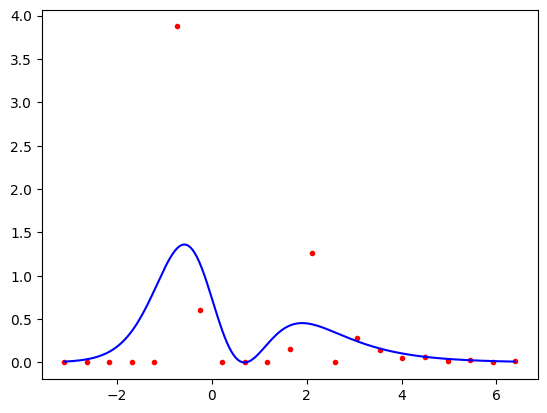

In [16]:
plot.plot(*sechApprox, '.', c='red')

zGrid = Grid1(zMin,zMax, nPlot)
pdfGrid = tuple(dist.Pdf(map_.Inverse(z)) for z in zGrid)

plot.plot(zGrid, pdfGrid, c='blue')

In [17]:
extZRange = tuple(z*s for (z,s) in zip((zMin,zMax), (2,2)))
extZRange

(-6.205204274600211, 12.787051700707842)

In [18]:
def Interp0(sechZ,sechV,h, z):
	result = sum(sv * BaseZ(z,sz,h) for (sz,sv) in zip(sechZ, sechV))

	return result

In [19]:
def Interp1(sechApprox, zGrid):
	sechZ,sechV = sechApprox
	
	nSech = len(sechZ)
	zMin,zMax = (sechZ[0], sechZ[nSech - 1])
	h = (zMax - zMin) / (nSech - 1)
	
	result = tuple(Interp0(sechZ,sechV,h, z) for z in zGrid)
	return result

(0.0001, 2)

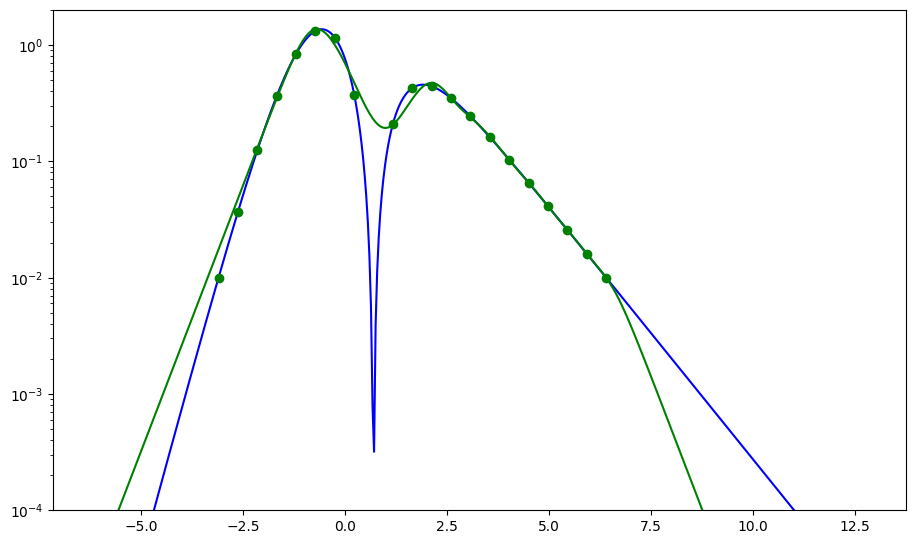

In [20]:
fig,ax = plot.subplots(figsize=(11, 6.5))

zGrid = Grid1(*extZRange, 501)
pdf = tuple(PdfZ(z) for z in zGrid)
plot.semilogy(zGrid,pdf, c='blue')

est = Interp1(sechApprox, zGrid)
plot.semilogy(zGrid,est, c='green')

sechZ,weight = sechApprox
sechV = tuple(PdfZ(z) for z in sechZ)
plot.semilogy(sechZ,sechV, 'o', c='green')
	
ax.set_ylim(1e-4,2)

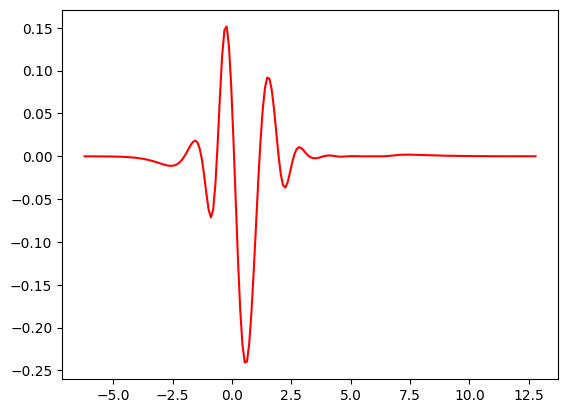

In [21]:
zGrid = Grid1(*extZRange, nPlot)
est = Interp1(sechApprox, zGrid)
pdf = tuple(dist.Pdf(map_.Inverse(z)) for z in zGrid)
diff = tuple(p - e for (p,e) in zip(pdf,est))

plot.plot(zGrid, diff, c='red')

# plot.plot(zGrid, pdf, c='blue')
# plot.plot(zGrid, est, c='green')

In [22]:
def ErrorZ(sechApprox, F):
	sechZ,weight = sechApprox
	
	nSech = len(sechZ)
	zMin,zMax = sechZ[0],sechZ[nSech - 1]
	h = (zMax - zMin) / (nSech - 1)
		
	Diff = lambda z: Interp0(sechZ,weight,h, z) - F(z)
	
	extZRange = tuple(z * s for (z,s) in zip((zMin,zMax), (2,2)))
	nSinc = 4 * nSech
	
	sincZ = Grid1(*extZRange, nSinc)
	diff = tuple(Diff(z) for z in sincZ)
	
	result = sqrt(h * sum(d*d for d in diff))
	return result

In [23]:
PdfZ = lambda z: dist.Pdf(map_.Inverse(z))

In [24]:
ErrorZ(sechApprox, PdfZ)

0.30313234140529133

In [25]:
def ErrN(F, nSech, zRange):
	sechEst,condNum = Fit(zRange,nSech)

	errEst = ErrorZ(sechEst, F)
	
	return (errEst, condNum)

In [26]:
def LogGridInt(min_,max_, nResult):
	lnMax = log(max_)
	
	result = [min_]
	val = min_
	
	for k in range(nResult - 1):
		nextGrid = round(val * exp((lnMax - log(val)) / (nResult - k - 1)))
		val = max(val + 1, nextGrid)
		
		result.append(val)
	  
	return result

In [27]:
nN = 50
nLim = (3,150)
nRange = LogGridInt(*nLim, nN)

In [28]:
errN = tuple((n,ErrN(PdfZ,n,(zMin,zMax))) for n in nRange)

F:\Users\Kenne.DESKTOP-BT6VROU\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


In [29]:
nL,info = UnZip(errN)
err,cond = UnZip(info)

In [30]:
fitRange = (5,25)

In [31]:
fitIndex = IndexOf(nL, lambda n: (fitRange[0] <= n) and (n <= fitRange[1]))
fitIndex

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [32]:
fitIndex = IndexOf(nL, lambda n: (5 <= n) and (n <= 21))
nSub = Sub(nL, fitIndex)
lnErr = tuple(log(e) for e in Sub(err, fitIndex))

slope,inter,_,_,_ = linregress(nSub,lnErr)
Fit = lambda n: exp(inter) * exp(slope * n)
InvFit = lambda err: (log(err) - inter) / slope

slope,exp(inter)

(-0.10805873977751625, 3.0291936273929343)

Text(0, 0.5, 'RMS Error')

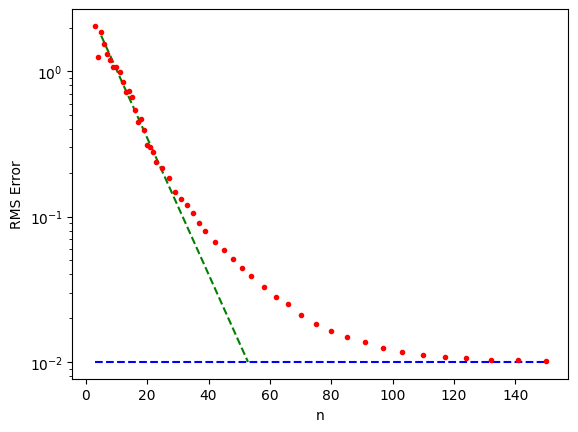

In [33]:
fig,ax = plot.subplots()

plot.semilogy(nL,err, '.', c='red')

nLim = MinMax(nRange)
plot.semilogy(nLim, tuple(truncStep for _ in range(2)), '--',c='blue', zorder=-1)

nGrid = (fitRange[0], InvFit(truncStep))
fitGrid = tuple(map(Fit, nGrid))

plot.semilogy(nGrid,fitGrid, '--', c='green', zorder=-2)

plot.xlabel('n')
plot.ylabel('RMS Error')

#### try polynomial fit

In [34]:
fitLim = (15,80)

In [35]:
fitIndex = IndexOf(nL, lambda n: (fitLim[0] <= n) and (n <= fitLim[1]))

nFit = Sub(nL, fitIndex)
errFit = Sub(err, fitIndex)

lnNFit = tuple(log(n) for n in nFit)
lnErrFit = tuple(log(e) for e in errFit)

In [36]:
slope,inter,_,_,_ = linregress(lnNFit, lnErrFit)
Fit = lambda n: exp(inter) * n ** slope

slope,exp(inter)

(-2.196390204998793, 247.02612270269717)

Text(0, 0.5, 'RMS Error')

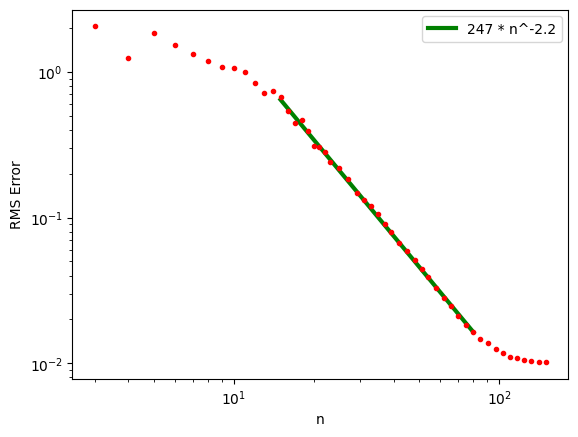

In [38]:
plot.loglog(nL,err, '.', c='red')

nGrid = fitLim
fitGrid = tuple(map(Fit, nGrid))

text = f'{round(exp(inter))} * n^{slope:.1f}'
plot.semilogy(nGrid,fitGrid, c='green', linewidth=3, zorder=-2, label=text)

plot.legend()
plot.xlabel('n')
plot.ylabel('RMS Error')